In [23]:
import numpy as np
import pandas as pd

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
dir_path = '/content/drive/MyDrive/Lab 6_NT522.P21.2/'

Load Dataset

In [26]:
X_train = pd.read_csv("/content/drive/MyDrive/Lab 6_NT522.P21.2/X_Train.csv",header=None)
Y_train = pd.read_csv("/content/drive/MyDrive/Lab 6_NT522.P21.2/Y_Train.csv",header=None)
X_test = pd.read_csv("/content/drive/MyDrive/Lab 6_NT522.P21.2/X_test.csv",header=None)
Y_test = pd.read_csv("/content/drive/MyDrive/Lab 6_NT522.P21.2/Y_test.csv",header=None)
key = pd.read_csv("/content/drive/MyDrive/Lab 6_NT522.P21.2/Key_feature.csv",header=None)

In [ ]:
'''
Giải đoạn này để đọc dữ liệu từ các file CSV đã lưu trữ trong Google Drive.
Các biến X_train, Y_train, X_test, Y_test và key sẽ chứa dữ liệu tương ứng.
Shape là số lượng mẫu và số lượng đặc trưng của dữ liệu.
X_train: Dữ liệu huấn luyện đầu vào.
Y_train: Nhãn của dữ liệu huấn luyện, là các nhãn tương ứng với X_train.
X_test: Dữ liệu kiểm tra đầu vào.
Y_test: Nhãn của dữ liệu kiểm tra, là các nhãn tương ứng với X_test.
key: Các đặc trưng quan trọng được xác định từ dữ liệu.
Dữ liệu được đọc từ các file CSV và lưu trữ trong các biến tương ứng.
'''

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(key.shape)


(250202, 115)
(250202, 1)
(13040, 115)
(13040, 1)
(10000, 115)


Training Model

In [ ]:
import numpy as np
import pandas as pd
import cudf
import cupy as cp
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.preprocessing import StandardScaler as cuStandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Chuyển đổi dữ liệu sang GPU
print("Đang chuyển dữ liệu lên GPU...")
X_train_gpu = cudf.DataFrame(X_train) # Chuyển đổi DataFrame Pandas sang DataFrame cuDF để xử lý trên GPU
Y_train_gpu = cudf.Series(Y_train.values.ravel()) # Chuyển đổi Series Pandas sang Series cuDF để xử lý trên GPU
X_test_gpu = cudf.DataFrame(X_test) # Chuyển đổi DataFrame Pandas sang DataFrame cuDF để xử lý trên GPU
Y_test_gpu = cudf.Series(Y_test.values.ravel()) # Chuyển đổi Series Pandas sang Series cuDF để xử lý trên GPU

# Chuẩn hóa dữ liệu trên GPU
print("Đang chuẩn hóa dữ liệu...")
scaler = cuStandardScaler() # Khởi tạo bộ chuẩn hóa dữ liệu, đây là bước quan trọng để đảm bảo rằng các đặc trưng có cùng quy mô, giúp mô hình học tốt hơn
# Bộ chuẩn hóa này sẽ tính toán trung bình và độ lệch chuẩn của từng đặc trưng trong tập huấn luyện và sử dụng chúng để chuẩn hóa cả tập huấn luyện và tập kiểm tra
X_train_scaled = scaler.fit_transform(X_train_gpu) # Chuẩn hóa dữ liệu huấn luyện, nghĩa là tính toán trung bình và độ lệch chuẩn của từng đặc trưng trong tập huấn luyện
# Sau đó, dữ liệu huấn luyện sẽ được chuẩn hóa bằng cách trừ đi trung bình và chia cho độ lệch chuẩn

X_test_scaled = scaler.transform(X_test_gpu) # Chuẩn hóa dữ liệu kiểm tra, nghĩa là sử dụng trung bình và độ lệch chuẩn đã tính toán từ tập huấn luyện để chuẩn hóa tập kiểm tra
# Khởi tạo và train model Random Forest trên GPU
rf_model = cuRF(
    n_estimators=100, # đây là số lượng cây trong rừng, càng nhiều cây thì mô hình càng chính xác nhưng cũng tốn thời gian huấn luyện hơn
    max_depth=10, # đây là độ sâu tối đa của mỗi cây, giới hạn này giúp tránh overfitting, càng sâu thì mô hình càng phức tạp và dễ overfit
    random_state=42, # đây là hạt giống ngẫu nhiên để đảm bảo tính tái lập của mô hình, nếu không đặt thì mỗi lần chạy sẽ cho kết quả khác nhau
    n_streams=1, # đây là số luồng xử lý song song, nếu bạn có nhiều GPU thì có thể tăng giá trị này để tận dụng tối đa tài nguyên
    max_features='sqrt', # đây là số lượng đặc trưng được chọn ngẫu nhiên cho mỗi cây, 'sqrt' có nghĩa là lấy căn bậc hai của tổng số đặc trưng, giúp giảm thiểu overfitting
    verbose=True # đây là tùy chọn để hiển thị thông tin chi tiết trong quá trình huấn luyện, nếu bạn muốn theo dõi tiến độ thì có thể để True
)

Đang chuyển dữ liệu lên GPU...
Đang chuẩn hóa dữ liệu...


In [ ]:
# Train model
print("Đang train model trên GPU...")
start_time = time.time()
rf_model.fit(X_train_scaled, Y_train_gpu) # Huấn luyện mô hình Random Forest trên dữ liệu đã chuẩn hóa
training_time = time.time() - start_time
print(f"Thời gian training: {training_time:.2f} giây")

Đang train model trên GPU...
Thời gian training: 1.81 giây


Evaluating Model

Đang dự đoán trên tập test...

=== KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP ===
Accuracy (Độ chính xác): 0.9757
Precision (Độ chính xác dương): 0.9774
Recall (Độ bao phủ): 0.9757
F1-score (Điểm F1): 0.9759

Đã lưu confusion matrix vào file 'confusion_matrix.png'


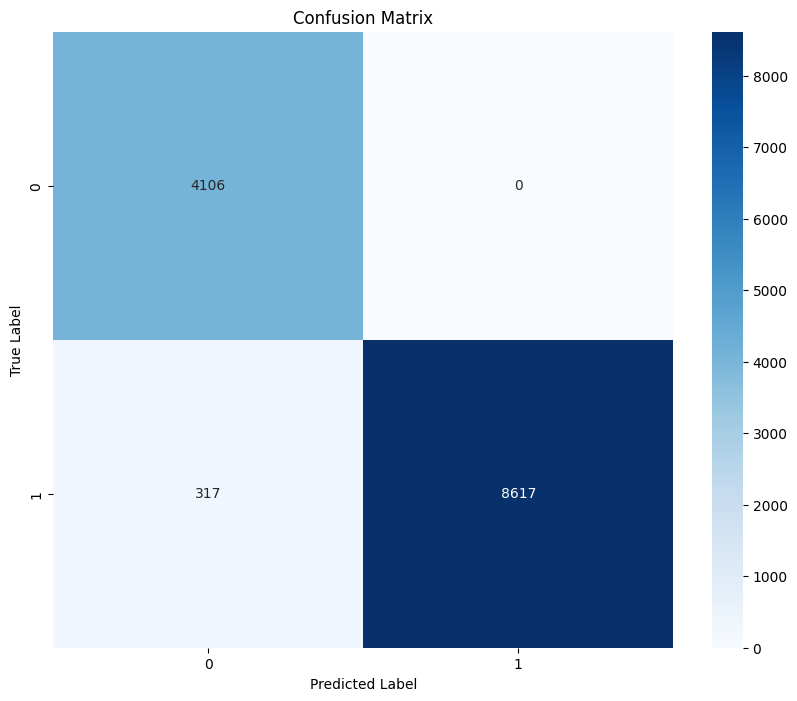

In [ ]:
# Dự đoán trên tập test
print("Đang dự đoán trên tập test...")
y_pred_gpu = rf_model.predict(X_test_scaled) # Dự đoán nhãn cho tập kiểm tra bằng mô hình đã huấn luyện

# Chuyển kết quả về CPU để đánh giá
y_pred = y_pred_gpu.values.get() # Chuyển đổi kết quả dự đoán từ cuDF Series sang NumPy array để có thể sử dụng với các hàm đánh giá của scikit-learn
y_test = Y_test_gpu.values.get() # Chuyển đổi nhãn thực tế từ cuDF Series sang NumPy array
# Tính toán các thang đo tổng hợp
accuracy = accuracy_score(y_test, y_pred) # Tính độ chính xác của mô hình bằng cách so sánh nhãn dự đoán với nhãn thực tế
precision = precision_score(y_test, y_pred, average='weighted') # Tính độ chính xác dương của mô hình, trung bình theo trọng số để cân nhắc số lượng mẫu của mỗi lớp
recall = recall_score(y_test, y_pred, average='weighted') # Tính độ bao phủ của mô hình, trung bình theo trọng số để cân nhắc số lượng mẫu của mỗi lớp
f1 = f1_score(y_test, y_pred, average='weighted') # Tính điểm F1 của mô hình, trung bình theo trọng số để cân nhắc số lượng mẫu của mỗi lớp

print("\n=== KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP ===")
print(f"Accuracy (Độ chính xác): {accuracy:.4f}") # In ra độ chính xác của mô hình, là tỷ lệ mẫu dự đoán đúng trên tổng số mẫu
print(f"Precision (Độ chính xác dương): {precision:.4f}") # In ra độ chính xác dương của mô hình, là tỷ lệ mẫu dự đoán đúng trên tổng số mẫu dự đoán là dương
print(f"Recall (Độ bao phủ): {recall:.4f}") # In ra độ bao phủ của mô hình, là tỷ lệ mẫu dự đoán đúng trên tổng số mẫu thực tế là dương
print(f"F1-score (Điểm F1): {f1:.4f}") # In ra điểm F1 của mô hình, là trung bình hài hòa giữa độ chính xác dương và độ bao phủ

# Vẽ confusion matrix
plt.figure(figsize=(10, 8)) 
cm = confusion_matrix(y_test, y_pred) # Tính toán confusion matrix bằng cách so sánh nhãn thực tế với nhãn dự đoán
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # Vẽ confusion matrix bằng seaborn, với các giá trị được ghi chú và màu sắc là xanh lam
plt.title('Confusion Matrix') # Tiêu đề của biểu đồ confusion matrix
plt.ylabel('True Label') # Nhãn thực tế
plt.xlabel('Predicted Label') # Nhãn dự đoán
plt.savefig('confusion_matrix.png') # Lưu confusion matrix vào file
print("\nĐã lưu confusion matrix vào file 'confusion_matrix.png'")


Hint Flag

In [33]:
f = np.zeros((200, 50))

In [ ]:
f